# **RNN / LSTM（old-newspapers.tsv）**

### **Table of Contents**：
- [Load Data](#載入資料)
- [Data Preprocessing](#前處理)
- [Tokenization Dic](#建立字典)
- [Data Batching](#資料分批)
- [Model Architecture](#模型設計)
- [Hyperperamemters](#超參數)
- [Training](#訓練)
    - [RNN First Train](#訓練)
    - [RNN Second Train](#訓練)
    - [LSTM First Train](#訓練)
    - [LSTM Second Train](#訓練)
    - [Comparison and Analysis](#訓練)
- [Generation](#生成)


### **Data Source**
- [Kaggle HC 新聞資料集](https://www.kaggle.com/alvations/old-newspapers#old-newspaper.tsv)

## **RNN（Recurrent Neural Network）**
一種專門用來處理「序列資料」的神經網路，與一般前饋神經網路（Feedforward Neural Network）不同，RNN 具有「記憶」功能，它能夠考慮到前一時刻的輸入，讓目前的輸出不只依賴當下的輸入，也會受到過去資料的影響。

- **應用**：
1. 天氣預測
2. 股價短期波動
3. 簡單時間序列

- **架構**：

在 RNN 中，每一個時間步（time step）都會將輸入傳入一個「隱藏層狀態」`h_t`，這個狀態會根據當下的輸入 `x_t` 和前一個狀態 `h_{t-1}` 一起計算出來：

- **問題**：

RNN 雖然能記住之前的資訊，但在實作上會遇到 **梯度消失（vanishing gradient）或爆炸（exploding gradient）** 的問題，導致無法有效記住長期依賴（long-term dependency）。


## **LSTM（Long Short-Term Memory）**

一種特殊的 RNN 結構，被設計來解決原始 RNN 在處理長期依賴時的問題，透過「門控機制」來選擇性地保留重要的資訊、忘記不重要的資訊。

- **應用**：

1. 語音辨識
2. 機器翻譯
3. 聊天機器人
4. 手寫文字辨識

- **架構**：

LSTM 的核心是 **記憶單元（cell state）** 和三個「門」：
1. **遺忘門（Forget Gate）**：決定要忘記多少舊資訊
2. **輸入門（Input Gate）**：決定要加入多少新資訊
3. **更新記憶單元**
4. **輸出門（Output Gate）**：決定輸出什麼資訊

- **優勢**：

1. 可有效處理長時間依賴問題
2. 不容易遇到梯度消失問題
3. 更適合用在像是語言模型、時間序列預測等應用


### **RNN vs. LSTM**

| 特性 | RNN | LSTM |
|------|-----|------|
| 記憶能力 | 短期 | 長期 |
| 門控機制 | 無 | 有（3個門） |
| 容易訓練問題 | 梯度消失/爆炸 | 較穩定 |
| 複雜度 | 簡單 | 較高 |
| 適用場景 | 簡單序列 | 長依賴的序列（語音、NLP等） |


## **RNN vs. LSTM 模型合理目標值設定**


| 模型 | val accuracy 合格 | 良好表現 | 優異表現 | 備註 |
|------|----------------------|----------|------------|------|
| **RNN（10 epochs）**| **25%** ↑ | **30% ↑** | **35~40% ↑** | 初次訓練：到達 28% 合格並接近良好；二次訓練：梯度爆炸，合格不到，訓練失敗|
| **LSTM（30 epochs）**| **20%** ↑ | **25% ↑** | **30% ↑** | 初次訓練：僅於 15.7%，underfitting；二次訓練：**val acc 達到 35%** 表現優異|

- **評估依據**

1. 資料集為繁體中文舊報紙，**難度高、語言特殊的領域語料**
2. 模型結構為**單純的 seq2label（embedding → RNN/LSTM → FC）**


In [2]:
!pip install opencc # 中文簡繁轉換工具


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.9 MB/s eta 0:00:0000:0100:01


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as torch_nn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import opencc
from tqdm import tqdm


## **Load Data**
- [下載](https://www.kaggle.com/alvations/old-newspapers#old-newspaper.tsv)資料
- `tsv` 檔案類似 `csv`，只是用 `\t` 做分隔符號
- 資料內容包含：

|欄位|意義|資料型態|
|-|-|-|
|`Language`|語系|文字（類別）|
|`Source`|新聞來源|文字|
|`Date`|時間|文字|
|`Text`|文字內容|文字|

In [ ]:
# run on kaggle
kaggle_path = os.listdir("/kaggle/input/")
print(kaggle_path)


## **Data Preprocessing**
- 訓練目標為生成繁體中文字
    - 所以只考量繁體中文的資料
    - 類別為 `Chinese (Traditional)`
    - 共約 333735 筆
- 資料長度不一
    - 畫出長度分佈圖
    - 計算長度四分位數、最小值、最大值

In [2]:
data_root = "old-newspaper.tsv"
df = pd.read_csv(data_root, delimiter="\t")

print(f"Nan counts: {df.info()}")  # dtype and Nan -> Nan counts: None
print("\n")
print(f"Data statistic:\n{df.describe()}")  # statistic
print("\n")

print(f"Data:\n{df.head()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16806041 entries, 0 to 16806040
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Language  object
 1   Source    object
 2   Date      object
 3   Text      object
dtypes: object(4)
memory usage: 512.9+ MB
Nan counts: None


Data statistic:
        Language    Source      Date                         Text
count   16806041  16806041  16806041                     16806039
unique        66       875      4740                     16797591
top      English   UNKNOWN   UNKNOWN  ជួបគ្នា 4 ប្រកួតចុងក្រោយគឺ៖
freq     1010242    309918    309918                          100


Data:
    Language              Source        Date  \
0  Afrikaans  republikein.com.na  2011/09/14   
1  Afrikaans  republikein.com.na  2011/01/20   
2  Afrikaans          sake24.com  2009/11/28   
3  Afrikaans          sake24.com  2009/11/12   
4  Afrikaans          sake24.com  2011/02/04   

                                                Te

In [9]:
# filter only getting Chinese (Traditional) data

print(f"Chinese (Traditional) counts：{df[df['Language'] == 'Chinese (Traditional)'].shape}")
df = df[df['Language'] == 'Chinese (Traditional)']

print(f"Nan counts: {df.info()}")  # dtype and Nan -> Nan counts: None
print("\n")
print(f"Data statistic:\n{df.describe()}")  # statistic
print("\n")

print(f"Data:\n{df.head()}")


Chinese (Traditional) counts：(333735, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 333735 entries, 1918193 to 2251927
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Language  333735 non-null  object
 1   Source    333735 non-null  object
 2   Date      333735 non-null  object
 3   Text      333735 non-null  object
dtypes: object(4)
memory usage: 12.7+ MB
Nan counts: None


Data statistic:
                     Language             Source        Date    Text
count                  333735             333735      333735  333735
unique                      1                 18        1939  333728
top     Chinese (Traditional)  big5.china.com.cn  2011/09/27     文：兒
freq                   333735              48425       14431       2


Data:
                      Language            Source        Date  \
1918193  Chinese (Traditional)     atchinese.com  2010/09/01   
1918194  Chinese (Traditional)  worldjournal.com  2010/0

In [10]:
# statistic of Text

df['text_len'] = df['Text'].apply(lambda x: len(str(x)))
print(df['text_len'].describe())
print(df[df['text_len'] == 40][["Text",'text_len']])
print(df['Text'][2251883])


count    333735.000000
mean         96.339979
std          71.330311
min           1.000000
25%          44.000000
50%          89.000000
75%         132.000000
max        3808.000000
Name: text_len, dtype: float64
                                             Text  text_len
1918297  200米個人混合泳金牌（今年世界第一），400米個人混合泳金牌（今年世界第二）。        40
1918487  胡尼先前擔任利比亞駐阿拉伯國家聯盟代表，利比亞2月爆發武裝衝突後辭職投向反對派。        40
1918731  鄭曉松還說，２０１０年，中國將繼續實行積極的財政政策，促進經濟社會平穩較快發展。        40
1918847  維多利亞致公堂抵押文件上也有謝秋的簽名。（加拿大《明報》/黎全恩教授發現兼提供）        40
1919135  網友“一葉秋水”：我和妻子已經同房三個月還沒有懷孕，是不是馬上要去醫院檢查一下？        40
...                                           ...       ...
2251199  2020年為止，上海風機轉動產電之時，兩電在港的風電場仍然是紙上談兵，並未動土。        40
2251279  找到原因之後，李暉找班主任老師和培訓點的校長都溝通過，希望能找到解決問題的辦法。        40
2251321  消費者信心攀升，有助緩解消費者支出搖搖欲墜的疑慮。消費支出趨緩恐將危及景氣復甦。        40
2251669  除了歐債危機和美國量化寬鬆政策外，2010年黃金市場的熱點莫過於中國因素的凸現。        40
2251883  中亞國家哈薩克總統認為「上海合作組織」六個成員國，有必要共建一體化能源運輸空間。        40

[1161 rows x 2 columns]
中亞國家哈薩克總統認為「上海合作組織」六個成員國，有必要共建一體化能源運輸空間。

Q1: 44.0
Q3: 132.0
IQR: 88.0
Lower Bound: -88.0
Upper Bound: 264.0
Outlier counts: 8037


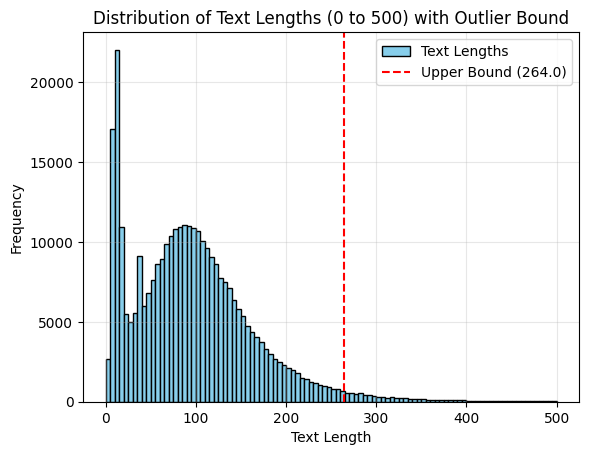

In [11]:
# Quartile and IQR（Interquartile Range)

Q1 = df['text_len'].quantile(0.25)
Q3 = df['text_len'].quantile(0.75)
IQR = Q3 - Q1 # 四分位距

# outlier bound - 涵蓋了大約 99.7% 的正常數據
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df['text_len'][(df['text_len'] < lower_bound) | (df['text_len'] > upper_bound)]

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Outlier counts: {len(outliers)}")

plt.hist(df['text_len'], bins=100, range=(0, 500), edgecolor='black', color='skyblue', label='Text Lengths')
if upper_bound <= 500:
    plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound ({upper_bound:.1f})')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths (0 to 500) with Outlier Bound')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## **字符級別 Tokenization Dic**

- 無法直接利用純文字進行計算
- **將所有文字轉換成數字（Token）**
    - 雙向映射的目的是為了方便將文字資料轉換成模型可以理解的數字形式（Input），並在模型生成結果時將數字轉回文字（Output）
- Vocabulary size:`8110`
- **Special tokens**:
    - '&lt;pad&gt;'
        - 每個 batch 所包含的句子長度不同
        - 將長度使用 '&lt;pad&gt;' **補成 batch 中最大值者**
    - '&lt;eos&gt;'
        - 指定序列的結束（end of sequence），**在生成任務中特別有用**
        - 沒有 '&lt;eos&gt;' 會不知道何時停止生成

In [12]:
# set a vocabulary

char_to_id = {}
id_to_char = {}

# add necessary special token first
char_to_id['<pad>'] = 0
char_to_id['<eos>'] = 1
id_to_char[0] = '<pad>'
id_to_char[1] = '<eos>'

for char in set(''.join(df['Text'])): # set() -> filter same text
    ch_id = len(char_to_id) # dynamic
    char_to_id[char] = ch_id
    id_to_char[ch_id] = char

'''
.str.cat()：專門處理 Pandas Series or DataFrame，將 row 中的所有文字串接成一個長字符串
    - 等同於 ''.join()
'''

vocab_size = len(char_to_id)
print('Vocabulary size: {}'.format(vocab_size))


Vocabulary size: 8110


In [13]:
# Tokenize

df['Tokenized'] = df['Text'].apply(lambda text: [char_to_id[char] for char in list(text)] + [char_to_id['<eos>']])
print(f"Data:\n{df[['Text', 'Tokenized']].head()}")


Data:
                                                      Text  \
1918193  方道生指，梁頌學的腦大靜脈由於受擠壓，之前有大約三分一的腦靜脈閉塞，問題嚴重，而菲國醫生用了...   
1918194  關於「建材下鄉」在市場上已傳聞許久。從去年9月起，中國相關行業協會和組織就已經開始為「建材下...   
1918195  報告說：“調查結果，令人非常失望。沒有一家企業能獲得最高的五星，近46%的企業處於零級。僅有...   
1918196  女人唔易做，美人更不易為。保養完美無瑕的外貌很倦人，剛顧及對抗臉上皺紋，又說頸紋更加暴露年紀...   
1918197  王奇說，由於很多人擔心課堂上就是用來分組玩牌，所以他只安排了非常少的實踐內容，大部分時間是講...   

                                                 Tokenized  
1918193  [5866, 7951, 2885, 4474, 546, 1853, 3550, 4227...  
1918194  [660, 7133, 100, 5237, 684, 2106, 1096, 2985, ...  
1918195  [4563, 4624, 6600, 5815, 3502, 5683, 7868, 612...  
1918196  [1967, 5332, 927, 1110, 6440, 546, 4932, 5332,...  
1918197  [2336, 1685, 6600, 546, 2550, 7133, 3933, 1670...  


## **Data Batching**
- `torch.utils.data.Dataset` 建立資料產生的工具 `dataset`
- `torch.utils.data.DataLoader` 對資料集 `dataset` 隨機抽樣並作為一個 batch

| 特性           | `torch.tensor`                                  | `torch.LongTensor`                               |
|----------------|-------------------------------------------------|-------------------------------------------------|
| **主要功能** | 通用張量，**根據輸入推斷數據類型或使用指定類型** | 專門用於創建 64 位有符號整數 (`torch.int64`) 張量 |
| **數據類型** | 靈活，可以根據輸入或 `dtype` 參數創建不同數據類型的張量 | **固定為 `torch.int64`** |
| **創建方式** | `torch.tensor(data, dtype=...)`                | `torch.LongTensor(data)`                         |
| **靈活性** | 更靈活，適用於創建各種數據類型的張量             | 數據類型固定，適用於需要長整型數據的場景         |
| **常用性** | **更常用，是創建張量的首選函數** | 在特定需要長整型數據的場景中使用，例如：**索引**   |
| **梯度追蹤** | 可以直接在創建時使用 `requires_grad` 參數指定     | 需要在創建後使用 `.requires_grad_(True)` 方法   |


In [14]:
# Data Batching

class CharDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __getitem__(self, index):
        '''
        input seq（x）, train how to predict the next seq of token (y)
        input:  A B C D E F
        output: B C D E F <eos>
        '''
        x = self.sequences.iloc[index][:-1] # filter '<eos>'
        y = self.sequences.iloc[index][1:] # filter the first token
        return x, y  # batch = [(x, y)···] depends on batch_size

    def __len__(self):
        return len(self.sequences)

# need for padding
def collate_fn(batch): # batch = (x, y)
    batch_x = [torch.tensor(data[0]) for data in batch] # list[torch.tensor]
    batch_y = [torch.tensor(data[1]) for data in batch] # list[torch.tensor]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    '''
    torch.LongTensor(...)：用於創建帶有 64 位有符號整數 (signed long integer) 數據類型的 tensor
        - 數據類型始終是 torch.int64
        - batch_x_lens = tensor([len(batch_x1), [len(batch_x2)])
        - batch_y_lens = tensor([len(batch_y1), [len(batch_y2)])
    '''

    '''
    torch.tensor
    [[1968, 1891, 3580, ... , 0, 0, 0],
     [1014, 2242, 2247, ... , 0, 0, 0],
     [3032,  522, 1485, ... , 0, 0, 0]]
                           padding↑
    '''

    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True, # shape=(batch_size, max_seq_len)
                                                  padding_value=char_to_id['<pad>'])

    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True, # shape=(batch_size, max_seq_len)
                                                  padding_value=char_to_id['<pad>'])

    '''
    torch.nn.utils.rnn.pad_sequence(...)：將變長序列填充成統一長度
        - tensor([2, 3, 4]) → 不變
        - tensor([4, 5]) → padding to tensor([4, 5, 0])
    '''
    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens



## **Model Architecture**

- **執行順序**：
1. **Embedding：把字符變成向量**
2. 按照句子順序將 embedding 丟入 RNN
3. RNN 的輸出再丟給下一層 RNN，可以接上更多層 -> **記住上下文**
4. 最後的 RNN 所有時間點的輸出丟進一層 Fully Connected -> **預測下一個字符**
5. 輸出結果所有維度中的最大者即為下一個字

- **損失函數**：分類任務 -> Cross Entropy
- **梯度更新**：Adam

In [15]:
# define Model Architecture - RNN

class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()

        # Embedding layer
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])

        '''
        padding_idx：忽略填充時的 0
        '''

        # RNN layer
        self.rnn_layer1 = torch.nn.RNN(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)

        self.rnn_layer2 = torch.nn.RNN(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)

        '''
        embed_dim：每個字符經 embedding 後的長度 -> 決定字符的「描述細緻度」
        hidden_size：RNN 記憶的大小，像是一個「記憶盒子」的容量
        batch_first=True：input shape (batch_size, seq_len, vocab_size)
        '''

        # output layer
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))
        '''
        Linear 最後把輸入 hidden_dim 長度的向量轉成一個長度為 vocab_size 的向量，表 logits
        '''

    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)

    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)

        '''
        .pack_padded_sequence()：壓縮序列，忽略（<pad>），只看真實內容，把「廢話」去掉，只看重點
        '''
        # 讓兩層 RNN 讀懂序列，記住上下文
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)

        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)

        '''
        .pad_packed_sequence()：還原序列，把壓縮的東西還原回來，方便後面處理
        '''
        # 預測下一個字符
        batch_x = self.linear(batch_x)
        return batch_x


    def generator(self, start_char, max_len=200):
        char_list = [char_to_id[start_char]]
        next_char = None

        # 生成的長度沒達到 max_len 就一直生
        while len(char_list) < max_len:
            x = torch.LongTensor(char_list).unsqueeze(0) # convert to tensor
            x = self.embedding(x)
            _, (ht, _) = self.rnn_layer1(x)
            _, (ht, _) = self.rnn_layer2(ht) # 跑兩層 RNN 得到最新記憶（ht）
            y = self.linear(ht) # 預測下一個字符的機率（y）

            next_char = np.argmax(y.numpy()) # 選機率最高的字符（next_char）的 id

            # '<eos>' means stop
            if next_char == char_to_id['<eos>']:
                break

            char_list.append(next_char)

        return [id_to_char[ch_id] for ch_id in char_list]


In [16]:
# define Model Architecture - LSTM

class CharLSTM(torch_nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharLSTM, self).__init__()

        self.embedding = torch_nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=char_to_id['<pad>']
        )

        # 2 LSTM layer
        self.lstm_layer1 = torch_nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.lstm_layer2 = torch_nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # output layer
        self.linear = torch_nn.Sequential(
            torch_nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            torch_nn.ReLU(),
            torch_nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        )

    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)

    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)  # (batch_size, seq_len, embed_dim)

        # 壓縮序列
        batch_x = torch_nn.utils.rnn.pack_padded_sequence(
            batch_x, batch_x_lens, batch_first=True, enforce_sorted=False
        )

        # 2 層 LSTM
        batch_x, _ = self.lstm_layer1(batch_x)
        batch_x, _ = self.lstm_layer2(batch_x)

        # 還原序列
        batch_x, _ = torch_nn.utils.rnn.pad_packed_sequence(batch_x, batch_first=True)

        batch_x = self.linear(batch_x)  # (batch_size, seq_len, vocab_size)
        return batch_x


    def generator(self, start_char, max_len=200):
        char_list = [char_to_id[start_char]]
        next_char = None

        # 生成的長度沒達到 max_len 就一直生
        while len(char_list) < max_len:
            x = torch.LongTensor(char_list).unsqueeze(0) # convert to tensor
            x = self.embedding(x)
            _, (ht, _) = self.rnn_layer1(x)
            _, (ht, _) = self.rnn_layer2(ht) # 跑兩層 RNN 得到最新記憶（ht）
            y = self.linear(ht) # 預測下一個字符的機率（y）

            next_char = np.argmax(y.numpy()) # 選機率最高的字符（next_char）的 id

            # '<eos>' means stop
            if next_char == char_to_id['<eos>']:
                break

            char_list.append(next_char)

        return [id_to_char[ch_id] for ch_id in char_list]


## **維度總變化**

- **Data**：df['char_id_list'] -> `seq`
- **Dataset**：x 和 y -> `(seq, seq)`
- **DataLoader**：
    1. pad_batch_x：`(batch_size, max_seq_len)`
    2. pad_batch_y：`(batch_size, max_seq_len)`
    3. batch_x_lens：`(batch_size)`
- **Model**：
    1. Input：`(batch_size, max_seq_len)`
    2. Embedding：`(batch_size, max_seq_len, embed_dim)`
    3. RNN：`(batch_size, max_seq_len, hidden_dim)`
    4. Output：`(batch_size, max_seq_len, vocab_size)`
- **Loss**：
    - output.view(-1, vocab_size)：`(batch_size * max_seq_len, vocab_size)`
    - batch_y.view(-1)：`(batch_size * max_seq_len)`
- **Acc**：
    - predictions：`(batch_size, max_seq_len)`

### **維度問題的常見陷阱**

1. Seq 長度不一致：用 **pad_sequence** 解決
2. Loss 維度：**CrossEntropyLoss 需要 2D 預測和 1D 目標**，所以用 view(-1, ...)
3. Data Batching：確保 **batch_first=True** 與 model 和 collate_fn 一致

## **Training**

- `for` 迴圈透過 `data_loader` 取得 batch
    1. 丟給 `model` 進行訓練
    2. 預測結果 `batch_pred_y` 跟真正的答案 `batch_y` 進行 Cross Entropy 得到誤差 `loss`
    3. 使用 `loss.backward` 自動計算梯度
    4. 使用 `torch.nn.utils.clip_grad_value_` 將梯度限制在 `-grad_clip` &lt; &lt; `grad_clip` 之間
    5. 使用 `optimizer.step()` 進行更新（back propagation）


In [17]:
# determine range
print(f"Lens of Text <= 500 counts: {df[df['text_len'] <= 500].shape[0]}")
print(f"Lens of Text >= 40 counts: {df[df['text_len'] >= 40].shape[0]}")
print(f"40 <= Lens of Text <= 500 counts: {df[(df['text_len'] >= 40) & (df['text_len'] <= 500)].shape[0]}")
print(f"40 <= Lens of Text <= 264 counts: {df[(df['text_len'] >= 40) & (df['text_len'] <= 264)].shape[0]}")

# filter dataset by text lengths
df_40_500 = df[(df['text_len'] >= 40) & (df['text_len'] <= 500)] # custom
df_40_264 = df[(df['text_len'] >= 40) & (df['text_len'] <= 264)] # upper_bound


Lens of Text <= 500 counts: 333315
Lens of Text >= 40 counts: 255846
40 <= Lens of Text <= 500 counts: 255426
40 <= Lens of Text <= 264 counts: 247809


## **初次嘗試 - 2 層 RNN（`RNN_df_40_500`）**

|超參數|意義|數值|
|-|-|-|
|`batch_size`|單一 batch 的資料數|128|
|`epochs`|總共訓練 epoch|10|
|`embed_dim`|文字的 embedding 維度|256|
|`hidden_dim`|RNN 中每個時間的 hidden state 維度|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|為了避免 RNN 出現梯度爆炸問題，將梯度限制範圍|1|

- 2 層 RNN
- lr = 0.001
- 無 weight decay
- 無 dropout
- data：df_40_500
- embed_dim = 256
- hidden_dim = 256

In [91]:
batch_size = 128
epochs = 10
embed_dim = 256
hidden_dim = 256
lr = 0.001
grad_clip = 1

Epoch 1 ------Train Loss: 5.1349 | Train Acc: 18.52%
Epoch 1 --------Val Loss: 4.5162 |   Val Acc: 23.82%
Saved best model at epoch 1  | Val Acc：23.82%
Saved best model at epoch 2  | Val Acc：25.70%
Saved best model at epoch 3  | Val Acc：26.34%
Saved best model at epoch 4  | Val Acc：26.99%
Epoch 5 ------Train Loss: 4.1642 | Train Acc: 26.98%
Epoch 5 --------Val Loss: 4.1551 |   Val Acc: 27.29%
Saved best model at epoch 5  | Val Acc：27.29%
Saved best model at epoch 6  | Val Acc：27.59%
Saved best model at epoch 7  | Val Acc：27.83%
Saved best model at epoch 8  | Val Acc：28.00%
Epoch 10------Train Loss: 4.0608 | Train Acc: 28.01%
Epoch 10--------Val Loss: 4.1071 |   Val Acc: 27.86%


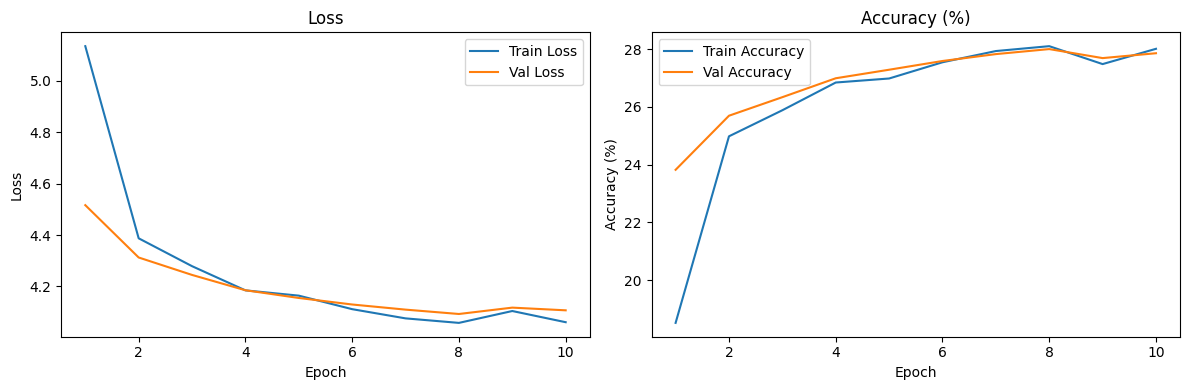

['.virtual_documents', 'RNN_df_40_500 training curves.png', 'Best_RNN_df_40_500.pth']


In [97]:
# 初次嘗試 - 2 層 RNN

class Training():
    def RNN(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 2. load CharRNN
        torch.manual_seed(2024)

        model = CharRNN(vocab_size,
                        embed_dim,
                        hidden_dim)

        model = model.to(device)


        # 3. define Loss function and optimizer
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'], reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        '''
        mean loss 讓不同長度的序列有一致的評分標準 -> 較穩定
        ignore_index=char_to_id['<pad>'] 重要
        '''
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 經過每 10 個 epoch，lr 變為原來的 0.1 倍

        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # for early stopping
        best_val_loss = float('inf')
        patience = 5
        counter = 0

        # 4. define train and val
        def train(epoch):
            model.train()
            total_loss = 0.0
            total_correct = 0
            total_predictions = 0

            for batch_x, batch_y, batch_x_lens, batch_y_lens in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                optimizer.zero_grad() # 清空舊梯度

                # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                output = model(batch_x, batch_x_lens)

                loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))
                '''
                CrossEntropyLoss 要求 input 是 (Sample, Class)
                    - 第一個參數：(id, vocab_size) 的預測得分
                    - 第二個參數：(id) 的真實目標 ID
                    - output.view(-1, vocab_size)：(batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
                    - batch_y.view(-1)：(batch_size, seq_len) -> (batch_size * seq_len)
                '''

                # Backward Propagation
                loss.backward() # 計算新梯度
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                optimizer.step() # 用裁剪後的梯度更新模型
                '''
                torch.nn.utils.clip_grad_value_：裁剪（clip）梯度值，加個「速度限制」，避免跑太快摔下山
                    - RNN 這種序列模型有時候梯度會變得非常大，為梯度爆炸 gradient explosion 導致：
                        1. 參數更新過大，模型「跳過」最佳解
                        2. 訓練不穩定，甚至損失變成 NaN（無效值）

                    - 具體作用：
                        1. 檢查模型的所有參數的梯度
                        2. 如果某個梯度的絕對值超過 grad_clip，就把它限制在 [-grad_clip, grad_clip] 範圍內

                    - 下劃線 _：表示直接修改參數的梯度（in-place 操作），而不是返回新值
                    - grad_clip：表示梯度的最大允許值，例如 1.0：
                        - 梯度 2.5 會被裁剪成 1.0
                        - 梯度 -1.8 會被裁剪成 -1.0
                        - 梯度 0.7 不變
                '''

                # calculate loss and acc
                total_loss += loss.item()
                predictions = torch.argmax(output, dim=-1) # 從 vocab_size 取得最大值的 index
                mask = (batch_y != char_to_id['<pad>'])
                correct = (predictions == batch_y) & mask
                total_correct += correct.sum().item()
                total_predictions += mask.sum().item()


            epoch_loss = total_loss / len(train_loader)
            epoch_acc = total_correct / total_predictions * 100

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            total_loss = 0
            total_correct = 0
            total_predictions = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for batch_x, batch_y, batch_x_lens, batch_y_lens in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                    # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                    output = model(batch_x, batch_x_lens)
                    loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))

                    # calculate loss and acc
                    total_loss += loss.item()
                    predictions = torch.argmax(output, dim=-1)
                    mask = (batch_y != char_to_id['<pad>'])
                    correct = (predictions == batch_y) & mask
                    total_correct += correct.sum().item()
                    total_predictions += mask.sum().item()

            epoch_loss = total_loss / len(val_loader)
            epoch_acc = 100. * total_correct / total_predictions
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_RNN_df_40_500.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

        # 5. training
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)
            scheduler.step()
            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1:<2}")
                    break

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('RNN_df_40_500 training curves.png')
        plt.show()

ret = Training()
ret.RNN()
print(os.listdir("/kaggle/working/"))


## **訓練結果（`RNN_df_40_500`）**

| 項目 | 2 層 RNN （10 epoch） | 
|------|----------------------|
| epochs | 10 |
| 最終 Val Accuracy | 約 **27.8%** |
| 最終 Train Accuracy | 約 28% | 
| Loss 趨勢 | 穩定收斂 | 
| 過擬合/欠擬合 | 幾乎無，表現穩定 | 

- **Loss**：
    1. 初始 loss 約為 5.2（Train）與 4.5（Val）
    2. 從第 1 到第 5 epoch 快速下降，之後趨於平緩
    3. 訓練與驗證 loss 收斂良好，gap 很小

- **Accuracy**：
    1. 初始 Accuracy 約為 18%（Train）與 24%（Val）
    2. 整體 accuracy 緩慢上升
    3. **第 10 epoch val accuracy 約為 27.8%**
    4. 模型沒有明顯 overfitting，train 與 val 的 accuracy 非常接近


## **二次嘗試 - 2 層 RNN（`RNN_df_40_264`）**

|超參數|意義|數值|
|-|-|-|
|`batch_size`|單一 batch 的資料數|128|
|`epochs`|總共訓練 epoch|10|
|`embed_dim`|文字的 embedding 維度|512|
|`hidden_dim`|RNN 中每個時間的 hidden state 維度|512|
|`lr`|Learning Rate|0.001|
|`grad_clip`|為了避免 RNN 出現梯度爆炸問題，將梯度限制範圍|1|

- 2 層 RNN
- lr = 0.001
- weight decay = 0.001
- 無 dropout
- data：df_40_264
- embed_dim = 512
- hidden_dim = 512

In [18]:
batch_size = 128
epochs = 10
embed_dim = 512
hidden_dim = 512
lr = 0.001
grad_clip = 1

Size of Train Dataset: 198247
Size of   Val Dataset: 49562
Epoch 1 ------Train Loss: 5.4861 | Train Acc: 15.44%
Epoch 1 --------Val Loss: 5.0903 |   Val Acc: 18.85%
Saved best model at epoch 1  | Val Acc：18.85%
Saved best model at epoch 2  | Val Acc：19.45%
Saved best model at epoch 3  | Val Acc：19.81%
Saved best model at epoch 4  | Val Acc：19.93%
Epoch 5 ------Train Loss: 4.9299 | Train Acc: 20.05%
Epoch 5 --------Val Loss: 4.9382 |   Val Acc: 19.94%
Saved best model at epoch 5  | Val Acc：19.94%
Saved best model at epoch 6  | Val Acc：20.14%
Epoch 10------Train Loss: 5.0985 | Train Acc: 18.57%
Epoch 10--------Val Loss: 5.0780 |   Val Acc: 18.70%


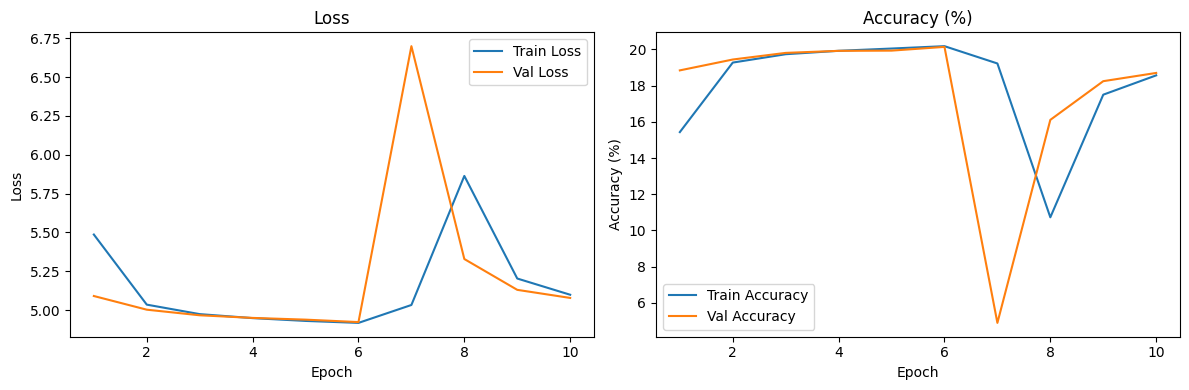

['Second-Train_RNN training curves.png', '.virtual_documents', 'Best_RNN_old-newspaper.pth']


In [19]:
# 二次嘗試 - 2 層 RNN

class Training():
    def RNN(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing - df_40_264
        train_seq, val_seq = train_test_split(df_40_264['Tokenized'], test_size=0.2, random_state=2024)

        train_dataset = CharDataset(train_seq)
        val_dataset = CharDataset(val_seq)

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  collate_fn=collate_fn,
                                  num_workers = 4,
                                  pin_memory=True)

        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=collate_fn,
                                num_workers = 4,
                                pin_memory=True)

        print(f"Size of Train Dataset: {len(train_dataset)}")
        print(f"Size of   Val Dataset: {len(val_dataset)}")


        # 2. load CharRNN
        torch.manual_seed(2024)

        model = CharRNN(vocab_size,
                        embed_dim,
                        hidden_dim)

        model = model.to(device)


        # 3. define Loss function and optimizer
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'], reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
        '''
        mean loss 讓不同長度的序列有一致的評分標準 -> 較穩定
        ignore_index=char_to_id['<pad>'] 重要
        '''
        # use ReduceLROnPlateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    mode='min',        # 監控指標是越小越好 (損失用 'min'，準確率用 'max')
                    factor=0.5,        #  -> 50% * lr
                    patience=3
                )
        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # for early stopping
        best_val_loss = float('inf')
        patience = 5
        counter = 0

        # 4. define train and val
        def train(epoch):
            model.train()
            total_loss = 0.0
            total_correct = 0
            total_predictions = 0

            for batch_x, batch_y, batch_x_lens, batch_y_lens in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                optimizer.zero_grad() # 清空舊梯度

                # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                output = model(batch_x, batch_x_lens)

                loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))
                '''
                CrossEntropyLoss 要求 input 是 (Sample, Class)
                    - 第一個參數：(id, vocab_size) 的預測得分
                    - 第二個參數：(id) 的真實目標 ID
                    - output.view(-1, vocab_size)：(batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
                    - batch_y.view(-1)：(batch_size, seq_len) -> (batch_size * seq_len)
                '''

                # Backward Propagation
                loss.backward() # 計算新梯度
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                optimizer.step() # 用裁剪後的梯度更新模型
                '''
                torch.nn.utils.clip_grad_value_：裁剪（clip）梯度值，加個「速度限制」，避免跑太快摔下山
                    - RNN 這種序列模型有時候梯度會變得非常大，為梯度爆炸 gradient explosion 導致：
                        1. 參數更新過大，模型「跳過」最佳解
                        2. 訓練不穩定，甚至損失變成 NaN（無效值）

                    - 具體作用：
                        1. 檢查模型的所有參數的梯度
                        2. 如果某個梯度的絕對值超過 grad_clip，就把它限制在 [-grad_clip, grad_clip] 範圍內

                    - 下劃線 _：表示直接修改參數的梯度（in-place 操作），而不是返回新值
                    - grad_clip：表示梯度的最大允許值，例如 1.0：
                        - 梯度 2.5 會被裁剪成 1.0
                        - 梯度 -1.8 會被裁剪成 -1.0
                        - 梯度 0.7 不變
                '''

                # calculate loss and acc
                total_loss += loss.item()
                predictions = torch.argmax(output, dim=-1) # 從 vocab_size 取得最大值的 index
                mask = (batch_y != char_to_id['<pad>'])
                correct = (predictions == batch_y) & mask
                total_correct += correct.sum().item()
                total_predictions += mask.sum().item()


            epoch_loss = total_loss / len(train_loader)
            epoch_acc = total_correct / total_predictions * 100

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            total_loss = 0
            total_correct = 0
            total_predictions = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for batch_x, batch_y, batch_x_lens, batch_y_lens in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                    # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                    output = model(batch_x, batch_x_lens)
                    loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))

                    # calculate loss and acc
                    total_loss += loss.item()
                    predictions = torch.argmax(output, dim=-1)
                    mask = (batch_y != char_to_id['<pad>'])
                    correct = (predictions == batch_y) & mask
                    total_correct += correct.sum().item()
                    total_predictions += mask.sum().item()

            epoch_loss = total_loss / len(val_loader)
            epoch_acc = 100. * total_correct / total_predictions
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_RNN_old-newspaper.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

            return epoch_loss

        # 5. run
        for epoch in range(epochs):
            train(epoch)
            val_loss = validate(epoch)
            scheduler.step(val_loss) # ReduceLROnPlateau

            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1:<2}")
                    break

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('Second-Train_RNN.png')
        plt.show()

ret = Training()
ret.RNN()
print(os.listdir("/kaggle/working/"))


## **訓練結果（`RNN_df_40_264`）**

| 項目 | RNN 模型（10 epoch） |
|------|------------------------|
| epochs | 10 |
| 最終 Val Accuracy |  **18.70** |
| 最終 Train Accuracy |  18.57|
| Loss 趨勢 | 過程有劇烈震盪 |
| 過擬合/欠擬合 |  overfitting + collapse |

- **Loss**：

    1. 初期有下降趨勢，但第 7~8 epoch 出現 loss 激增
    2. Val Loss 第 7 epoch 急升至 6.7 多，顯示模型輸出異常，應為梯度爆炸
    3. 最後 loss 又回穩，收斂到 5.0 附近，但未比第一張優

- **Accuracy**：

    1. 全程上下起伏劇烈，呈現過度波動與不穩定現象
    2. 最後回升至 ~19%，但整體趨勢不樂觀
    3. 梯度爆炸可能導致學習過程中途失敗，出現表現差距


## **初次嘗試 - 2 層 LSTM（`LSTM_df_40_264`）**

|超參數|意義|數值|
|-|-|-|
|`batch_size`|單一 batch 的資料數|128|
|`epochs`|總共訓練 epoch|30|
|`embed_dim`|文字的 embedding 維度|512|
|`hidden_dim`|RNN 中每個時間的 hidden state 維度|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|為了避免 RNN 出現梯度爆炸問題，將梯度限制範圍|1|

- 2 層 LSTM
- lr = 0.001
- weight decay = 0.001
- dropout -> 0.5
- data：df_40_264
- embed_dim = 512
- hidden_dim = 256


In [24]:
batch_size = 128
epochs = 30
embed_dim = 512
hidden_dim = 256
lr = 0.001
grad_clip = 1

Size of Train Dataset: 198247
Size of   Val Dataset: 49562
Epoch 1 ------Train Loss: 6.1796 | Train Acc: 8.30%
Epoch 1 --------Val Loss: 5.7222 |   Val Acc: 12.13%
Saved best model at epoch 1  | Val Acc：12.13%
Saved best model at epoch 2  | Val Acc：14.12%
Saved best model at epoch 3  | Val Acc：14.73%
Saved best model at epoch 4  | Val Acc：14.77%
Epoch 5 ------Train Loss: 5.6078 | Train Acc: 13.50%
Epoch 5 --------Val Loss: 5.4546 |   Val Acc: 14.75%
Saved best model at epoch 6  | Val Acc：15.14%
Saved best model at epoch 7  | Val Acc：15.21%
Saved best model at epoch 8  | Val Acc：15.35%
Epoch 10------Train Loss: 5.5718 | Train Acc: 13.85%
Epoch 10--------Val Loss: 5.4304 |   Val Acc: 15.40%
Saved best model at epoch 10 | Val Acc：15.40%
Saved best model at epoch 11 | Val Acc：15.55%
Epoch 15------Train Loss: 5.5593 | Train Acc: 14.00%
Epoch 15--------Val Loss: 5.4096 |   Val Acc: 15.43%
Epoch 20------Train Loss: 5.5523 | Train Acc: 14.05%
Epoch 20--------Val Loss: 5.3938 |   Val Acc: 15.53

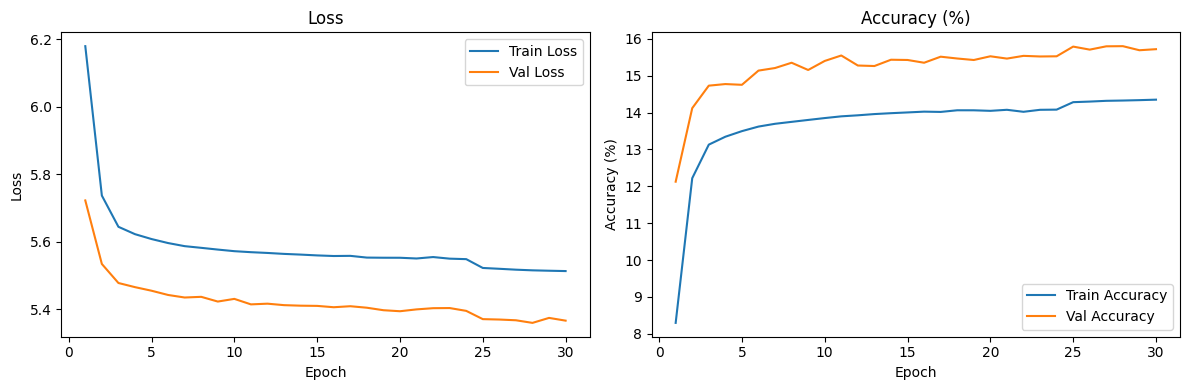

['RNN_df_40_500 training curves.png', '.virtual_documents', 'Best_RNN_df_40_500.pth']


In [25]:
# 初次嘗試 - 2 層 LSTM

class Training():
    def LSTM(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing - df_40_264
        train_seq, val_seq = train_test_split(df_40_264['Tokenized'], test_size=0.2, random_state=2024)

        train_dataset = CharDataset(train_seq)
        val_dataset = CharDataset(val_seq)

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  collate_fn=collate_fn,
                                  num_workers = 4,
                                  pin_memory=True)

        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=collate_fn,
                                num_workers = 4,
                                pin_memory=True)

        print(f"Size of Train Dataset: {len(train_dataset)}")
        print(f"Size of   Val Dataset: {len(val_dataset)}")


        # 2. load CharLSTM
        torch.manual_seed(2024)

        model = CharLSTM(vocab_size,
                        embed_dim,
                        hidden_dim)

        model = model.to(device)


        # 3. define Loss function and optimizer
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'], reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
        '''
        mean loss 讓不同長度的序列有一致的評分標準 -> 較穩定
        ignore_index=char_to_id['<pad>'] 重要
        '''
        # use ReduceLROnPlateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    mode='min',        # 監控指標是越小越好 (損失用 'min'，準確率用 'max')
                    factor=0.5,        #  -> 50% * lr
                    patience=3
                )
        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # for early stopping
        best_val_loss = float('inf')
        patience = 5
        counter = 0

        # 4. define train and val
        def train(epoch):
            model.train()
            total_loss = 0.0
            total_correct = 0
            total_predictions = 0

            for batch_x, batch_y, batch_x_lens, batch_y_lens in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                optimizer.zero_grad() # 清空舊梯度

                # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                output = model(batch_x, batch_x_lens)

                loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))
                '''
                CrossEntropyLoss 要求 input 是 (Sample, Class)
                    - 第一個參數：(id, vocab_size) 的預測得分
                    - 第二個參數：(id) 的真實目標 ID
                    - output.view(-1, vocab_size)：(batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
                    - batch_y.view(-1)：(batch_size, seq_len) -> (batch_size * seq_len)
                '''

                # Backward Propagation
                loss.backward() # 計算新梯度
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                optimizer.step() # 用裁剪後的梯度更新模型
                '''
                torch.nn.utils.clip_grad_value_：裁剪（clip）梯度值，加個「速度限制」，避免跑太快摔下山
                    - RNN 這種序列模型有時候梯度會變得非常大，為梯度爆炸 gradient explosion 導致：
                        1. 參數更新過大，模型「跳過」最佳解
                        2. 訓練不穩定，甚至損失變成 NaN（無效值）

                    - 具體作用：
                        1. 檢查模型的所有參數的梯度
                        2. 如果某個梯度的絕對值超過 grad_clip，就把它限制在 [-grad_clip, grad_clip] 範圍內

                    - 下劃線 _：表示直接修改參數的梯度（in-place 操作），而不是返回新值
                    - grad_clip：表示梯度的最大允許值，例如 1.0：
                        - 梯度 2.5 會被裁剪成 1.0
                        - 梯度 -1.8 會被裁剪成 -1.0
                        - 梯度 0.7 不變
                '''

                # calculate loss and acc
                total_loss += loss.item()
                predictions = torch.argmax(output, dim=-1) # 從 vocab_size 取得最大值的 index
                mask = (batch_y != char_to_id['<pad>'])
                correct = (predictions == batch_y) & mask
                total_correct += correct.sum().item()
                total_predictions += mask.sum().item()


            epoch_loss = total_loss / len(train_loader)
            epoch_acc = total_correct / total_predictions * 100

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            total_loss = 0
            total_correct = 0
            total_predictions = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for batch_x, batch_y, batch_x_lens, batch_y_lens in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                    # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                    output = model(batch_x, batch_x_lens)
                    loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))

                    # calculate loss and acc
                    total_loss += loss.item()
                    predictions = torch.argmax(output, dim=-1)
                    mask = (batch_y != char_to_id['<pad>'])
                    correct = (predictions == batch_y) & mask
                    total_correct += correct.sum().item()
                    total_predictions += mask.sum().item()

            epoch_loss = total_loss / len(val_loader)
            epoch_acc = 100. * total_correct / total_predictions
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_LSTM_df_40_264.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

            return epoch_loss

        # 5. run
        for epoch in range(epochs):
            train(epoch)
            val_loss = validate(epoch)
            scheduler.step(val_loss)

            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1:<2}")
                    break

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('LSTM_df_40_264 training curves.png')
        plt.show()

ret = Training()
ret.LSTM()
print(os.listdir("/kaggle/working/"))


## **訓練結果（`LSTM_df_40_264`）**

| 項目 | LSTM 模型（30 epoch） |
|------|------------------------|
| epochs | 30 |
| 最終 Val Accuracy |  約 **15.7%** |
| 最終 Train Accuracy |  約 14.4% |
| Loss 趨勢 | 穩定收斂，但 train loss 偏高 |
| 過擬合/欠擬合 |  train < val，可能有 underfitting |

- **Loss**：
    1. 初始 loss 約為 6.2（Train）與 5.7（Val）
    2. 前幾個 epoch 大幅下降，之後趨於平穩
    2. 訓練 loss 比驗證 loss **高**

- **Accuracy**：
    1. 初始 accuracy 約為 8%（Train）與 13%（Val）
    2. 在前 5 個 epoch 大幅提升後，漸趨穩定
    3. **第 30 epoch val accuracy 約為 15.7%**
    4. 訓練 accuracy 約為 14.4%，小於驗證 accuracy，代表模型 underfitting 或正則化過強


## **二次嘗試 - 2 層 LSTM**

|超參數|意義|數值|
|-|-|-|
|`batch_size`|單一 batch 的資料數|128|
|`epochs`|總共訓練 epoch|30|
|`embed_dim`|文字的 embedding 維度|512|
|`hidden_dim`|RNN 中每個時間的 hidden state 維度|512|
|`lr`|Learning Rate|0.001|
|`grad_clip`|為了避免 RNN 出現梯度爆炸問題，將梯度限制範圍|1|

- 2 層 LSTM
- lr = 0.001
- weight decay = 0.00001
- dropout -> X
- data：df_40_264
- embed_dim = 512
- hidden_dim = 512


In [17]:
batch_size = 128
epochs = 30
embed_dim = 512
hidden_dim = 512
lr = 0.001
grad_clip = 1

Size of Train Dataset: 198247
Size of   Val Dataset: 49562
Epoch 1 ------Train Loss: 4.8345 | Train Acc: 21.65%
Epoch 1 --------Val Loss: 4.2214 |   Val Acc: 27.40%
Saved best model at epoch 1  | Val Acc：27.40%
Saved best model at epoch 2  | Val Acc：29.73%
Saved best model at epoch 3  | Val Acc：30.95%
Saved best model at epoch 4  | Val Acc：31.69%
Epoch 5 ------Train Loss: 3.7131 | Train Acc: 32.50%
Epoch 5 --------Val Loss: 3.7399 |   Val Acc: 32.27%
Saved best model at epoch 5  | Val Acc：32.27%
Saved best model at epoch 6  | Val Acc：32.66%
Saved best model at epoch 7  | Val Acc：32.97%
Saved best model at epoch 8  | Val Acc：33.26%
Saved best model at epoch 9  | Val Acc：33.46%
Epoch 10------Train Loss: 3.5503 | Train Acc: 34.40%
Epoch 10--------Val Loss: 3.6228 |   Val Acc: 33.65%
Saved best model at epoch 10 | Val Acc：33.65%
Saved best model at epoch 11 | Val Acc：33.78%
Saved best model at epoch 12 | Val Acc：33.95%
Saved best model at epoch 13 | Val Acc：34.09%
Saved best model at epoch

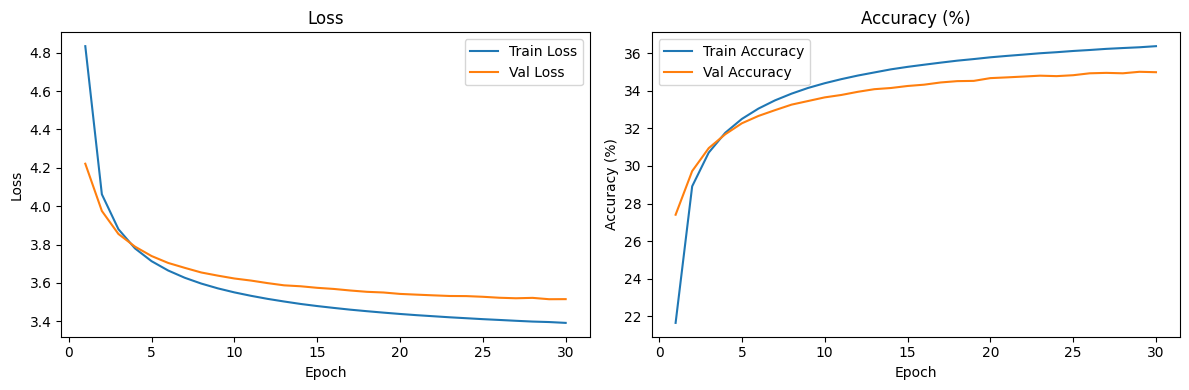

['LSTM_df_40_264 training curves.png', 'Best_LSTM_df_40_264.pth', '.virtual_documents']


In [20]:
# 二次嘗試 - 2 層 LSTM

class Training():
    def LSTM(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing - df_40_264
        train_seq, val_seq = train_test_split(df_40_264['Tokenized'], test_size=0.2, random_state=2024)

        train_dataset = CharDataset(train_seq)
        val_dataset = CharDataset(val_seq)

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  collate_fn=collate_fn,
                                  num_workers = 4,
                                  pin_memory=True)

        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=collate_fn,
                                num_workers = 4,
                                pin_memory=True)

        print(f"Size of Train Dataset: {len(train_dataset)}")
        print(f"Size of   Val Dataset: {len(val_dataset)}")


        # 2. load CharLSTM
        torch.manual_seed(2024)

        model = CharLSTM(vocab_size,
                        embed_dim,
                        hidden_dim)

        model = model.to(device)


        # 3. define Loss function and optimizer
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'], reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5) # 1e-3 -> 1e-5
        '''
        mean loss 讓不同長度的序列有一致的評分標準 -> 較穩定
        ignore_index=char_to_id['<pad>'] 重要
        '''
        # use ReduceLROnPlateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    mode='min',        # 監控指標是越小越好 (loss用 'min'，acc用 'max')
                    factor=0.5,        #  -> 50% * lr
                    patience=3
                )
        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # for early stopping
        best_val_loss = float('inf')
        patience = 5
        counter = 0

        # 4. define train and val
        def train(epoch):
            model.train()
            total_loss = 0.0
            total_correct = 0
            total_predictions = 0

            for batch_x, batch_y, batch_x_lens, batch_y_lens in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                optimizer.zero_grad() # 清空舊梯度

                # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                output = model(batch_x, batch_x_lens)

                loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))
                '''
                CrossEntropyLoss 要求 input 是 (Sample, Class)
                    - 第一個參數：(id, vocab_size) 的預測得分
                    - 第二個參數：(id) 的真實目標 ID
                    - output.view(-1, vocab_size)：(batch_size, seq_len, vocab_size) -> (batch_size * seq_len, vocab_size)
                    - batch_y.view(-1)：(batch_size, seq_len) -> (batch_size * seq_len)
                '''

                # Backward Propagation
                loss.backward() # 計算新梯度
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                optimizer.step() # 用裁剪後的梯度更新模型
                '''
                torch.nn.utils.clip_grad_value_：裁剪（clip）梯度值，加個「速度限制」，避免跑太快摔下山
                    - RNN 這種序列模型有時候梯度會變得非常大，為梯度爆炸 gradient explosion 導致：
                        1. 參數更新過大，模型「跳過」最佳解
                        2. 訓練不穩定，甚至損失變成 NaN（無效值）

                    - 具體作用：
                        1. 檢查模型的所有參數的梯度
                        2. 如果某個梯度的絕對值超過 grad_clip，就把它限制在 [-grad_clip, grad_clip] 範圍內

                    - 下劃線 _：表示直接修改參數的梯度（in-place 操作），而不是返回新值
                    - grad_clip：表示梯度的最大允許值，例如 1.0：
                        - 梯度 2.5 會被裁剪成 1.0
                        - 梯度 -1.8 會被裁剪成 -1.0
                        - 梯度 0.7 不變
                '''

                # calculate loss and acc
                total_loss += loss.item()
                predictions = torch.argmax(output, dim=-1) # 從 vocab_size 取得最大值的 index
                mask = (batch_y != char_to_id['<pad>'])
                correct = (predictions == batch_y) & mask
                total_correct += correct.sum().item()
                total_predictions += mask.sum().item()


            epoch_loss = total_loss / len(train_loader)
            epoch_acc = total_correct / total_predictions * 100

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            total_loss = 0
            total_correct = 0
            total_predictions = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for batch_x, batch_y, batch_x_lens, batch_y_lens in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                    # Forward Propagation input (batch_x, batch_x_lens) -> output (batch_size, seq_len, vocab_size)
                    output = model(batch_x, batch_x_lens)
                    loss = loss_fn(output.view(-1, vocab_size), batch_y.view(-1))

                    # calculate loss and acc
                    total_loss += loss.item()
                    predictions = torch.argmax(output, dim=-1)
                    mask = (batch_y != char_to_id['<pad>'])
                    correct = (predictions == batch_y) & mask
                    total_correct += correct.sum().item()
                    total_predictions += mask.sum().item()

            epoch_loss = total_loss / len(val_loader)
            epoch_acc = 100. * total_correct / total_predictions
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_LSTM_df_40_264.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 Best_ResNet50.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

            return epoch_loss

        # 5. run
        for epoch in range(epochs):
            train(epoch)
            val_loss = validate(epoch)
            scheduler.step(val_loss)

            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1:<2}")
                    break

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy (%)')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('LSTM_df_40_264 training curves.png')
        plt.show()

ret = Training()
ret.LSTM()
print(os.listdir("/kaggle/working/"))


## **訓練結果（`LSTM_df_40_264`）**

| 項目 | LSTM 模型（30 epoch） |
|------|------------------------|
| epochs | 30 |
| 最終 Val Accuracy |  約 **35%** |
| 最終 Train Accuracy |  約 36.38% |
| Loss 趨勢 | 穩定收斂 |
| 過擬合/欠擬合 |  train ≅ val |

- **Loss**：
    1. **Train Loss 持續下降，訓練穩定**
      - 模型在訓練資料上的表現不斷進步，學習效果良好
      - 從第 1 到第 30 個 epoch，Train Loss 幾乎平滑下降，是訓練穩定的好現象

    2. **Validation Loss 也持續下降，但下降趨勢趨緩，無明顯 overfitting 現象**
      - Val Loss 沒出現明顯的「U-turn」上升，模型在這 30 個 epoch 中沒有 overfitting
      - 但 Val Loss 曲線從約第 15 個 epoch 開始下降趨勢趨緩，說明可能已經逼近最佳的泛化能力

- **Accuracy**：

    1. **Train Accuracy 不斷提升，最終約達到 36.5%**
    2. **Val Accuracy 也提升，最終約達到 35% 左右，但提升趨緩**
    3. 訓練準確率明顯高於驗證準確率，看下來算是正常現象
    4. 兩者差距不大，表示模型泛化能力尚可
    5. **模型能穩定提升準確率，並沒有出現訓練過頭導致驗證準確率下降的情況**


## **Comparison and Analysis**

- **背景與數據概述**
    - First-Train LSTM：第一訓練的 LSTM 模型，訓練 30 個 epoch。
    - First-Train RNN：第一訓練的 RNN 模型，訓練 10 個 epoch。
    - Second-Train LSTM：第二訓練的 LSTM 模型，訓練 30 個 epoch。
    - Second-Train RNN：第二訓練的 RNN 模型，訓練 10 個 epoch。
    
- **詳細數據與趨勢**

| 訓練情境 | 模型   | Epochs | Train Loss (約) | Val Loss (約) | Train acc(約) | Val acc (約) | 其他觀察       |
|----------|--------|--------|---------------|---------------|-----------------|-----------------|---------------|
| First    | LSTM   | 30     | 5.0-5.1       | 5.0           | 14.5-15%        | 15.5-16%        | 收斂良好，泛化能力尚可 |
| First    | RNN    | 10     | 4.1           | 4.1           | 27-28%          | 27-28%          | 收斂穩定，表現優異    |
| Second   | LSTM   | 30     | 3.5           | 3.6           | 36%             | 34%             | 收斂良好，表現最佳    |
| Second   | RNN    | 10     | 5.25          | 5.25          | 18%             | 18%             | 訓練不穩定，有波動    |


- **LSTM**
    - First-Train：Loss 約 5.0-5.1，Acc 14.5-15%，表現較弱。
    - Second-Train：Loss 約 3.5-3.6，Acc 36%，表現顯著提升。
    - 第二次訓練的 LSTM 參數調整後表現更佳

- **RNN** 
    - First-Train：Loss 約 4.1，Acc 27-28%，表現良好。
    - Second-Train：Loss 約 5.25，Acc 18%，表現下降，且訓練過程不穩定。
    - 第二次訓練的 RNN 有顯著的損失和準確率波動，特別是在第 6 和第 8 epoch，可能是 overfitting、hidden_dim 或 embed_dim 過高的問題。
